# Resolution Convolution (4D) Example

In [1]:
%matplotlib inline
import numpy as np
from neutronpy import Instrument, Sample
from neutronpy.instrument.tools import _modvec, _star
import matplotlib.pyplot as plt

In [2]:
import matplotlib as mpl
import neutronpy as npy

print('matplotlib version: ', mpl.__version__)
print('numpy version: ', np.__version__)
print('neutronpy version: ', npy.__version__)

matplotlib version:  2.0.0
numpy version:  1.12.1
neutronpy version:  1.0.3


In [3]:
def angle2(x, y, z, h, k, l, lattice):
    V, Vstar, latticestar = _star(lattice)

    return np.arccos(2 * np.pi * (h * x + k * y + l * z) / _modvec([x, y, z], lattice) / _modvec([h, k, l], latticestar))

def sqw(H, K, L, W, p=None):
    '''S(Q, w) for a gapped excitation in a 1D antiferromagnet'''
    
    dx, dy, dz, cc, gamma = p[:5]
    
    omega_x = np.sqrt(cc ** 2 * np.sin(2 * np.pi * H) ** 2 + dx ** 2)
    omega_y = np.sqrt(cc ** 2 * np.sin(2 * np.pi * H) ** 2 + dy ** 2)
    omega_z = np.sqrt(cc ** 2 * np.sin(2 * np.pi * H) ** 2 + dz ** 2)
    
    lor_x = 1 / np.pi * gamma / ((W - omega_x) ** 2 + gamma ** 2)
    lor_y = 1 / np.pi * gamma / ((W - omega_y) ** 2 + gamma ** 2)    
    lor_z = 1 / np.pi * gamma / ((W - omega_z) ** 2 + gamma ** 2)
    
    sqw = np.array([lor_x * (1 - np.cos(np.pi * H)) / omega_x / 2, 
                    lor_y * (1 - np.cos(np.pi * H)) / omega_y / 2, 
                    lor_z * (1 - np.cos(np.pi * H)) / omega_z / 2])

    return sqw
    
def pref(H, K, L, W, EXP, p=None):
    '''More complicated prefactor'''
    I, bgr = p[5:]
    
    
    sample, rsample = EXP.get_lattice()
    q2 = _modvec([H, K, L], rsample) ** 2
    sd = q2 / (16 * np.pi ** 2)
    ff = 0.0163 * np.exp(-35.883 * sd) + 0.3916 * np.exp(-13.223 * sd) + 0.6052 * np.exp(-4.339 * sd) - 0.0133
    
    
    # Calculate the polarization factors for transverse excitations
    alphay = angle2(0, 1, 0, H, K, L, sample)
    alphaz = angle2(0, 0, 1, H, K, L, sample)
    alphax = angle2(1, 0, 0, H, K, L, sample)

    # Polarization factors for each of the three modes.
    polx = np.sin(alphax) ** 2
    poly = np.sin(alphay) ** 2
    polz = np.sin(alphaz) ** 2

    prefactor = np.array([ff ** 2 * polx * I, ff ** 2 * poly * I, ff ** 2 * polz * I])

    # Constant Background
    bgr = np.ones(H.shape) * bgr
    
    return np.ones(H.shape)[np.newaxis, ...]

In [4]:
sample = Sample(4., 4., 4., 90, 90, 90, mosaic=60., u=[1, 0, 0], v=[0, 1, 0])

instr = Instrument(efixed=14.7, sample=sample, hcol=[50, 80, 50, 120], ana='PG(002)', mono='PG(002)', 
                   moncor=1, mono_mosaic=35., ana_mosaic=35.)

instr.mono.dir = 1
instr.sample.dir = -1
instr.ana.dir = 1

In [5]:
H1=1.5 
K1=0
L1=0.35
W1=np.arange(20, 0, -0.5)

q = [H1, K1, L1, W1]  # q = [2, -0.18, 0, eValues]

In [6]:
p = [3, 3, 3, 30, 0.4, 6e4, 40]

output_fix = instr.resolution_convolution(sqw, pref, 1, q, METHOD='fix', ACCURACY=[5,5], p=p)  # Fixed sample method

output_mc = instr.resolution_convolution(sqw, pref, 1, q, METHOD='mc', ACCURACY=[5], p=p)  # Monte Carlo Method

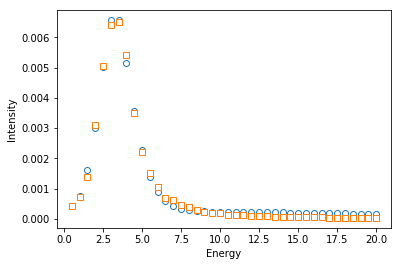

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(W1, output_fix, 'o', mfc='w')
ax.plot(W1, output_mc, 's', mfc='w')

ax.set_xlabel('Energy')
ax.set_ylabel('Intensity')